# Import data as 'df'

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('./london_weather.csv')
df.drop(columns = ['snow_depth'], inplace = True)
df.dropna(inplace= True)
df.reset_index(drop=True, inplace=True)

#get mean monthly temp
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year
df['month_year'] = pd.to_datetime(df['date']).dt.to_period('M')
df=df.groupby('month_year').mean()
df=df['mean_temp']
df=df.to_frame() #transfer 'df' from Series to DataFrame


df




,mean_temp
month_year,
1979-01,0.527586
1979-02,2.028000
1979-03,5.587097
1979-04,8.743333
1979-05,11.490323
...,...
2020-08,20.393333
2020-09,16.616667
2020-10,11.933333


# Find the optimal model by auto_arima

In [24]:
# Split data into train / test sets as the ratio of 8:2
n=int(len(df)*0.2)
train = df.iloc[:len(df)-n]
test = df.iloc[len(df)-n:]

In [25]:
# Import the library
from pmdarima import auto_arima
  
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

  
# Fit auto_arima function to AirPassengers dataset
stepwise_fit = auto_arima(df['mean_temp'], start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
  
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2054.865, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1907.077, Time=0.87 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2053.466, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2041.838, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1850.590, Time=1.33 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.41 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1870.217, Time=13.53 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1851.094, Time=1.78 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=1850.572, Time=2.44 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1908.002, Time=1.21 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=inf, Time=8.35 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  504
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -920.050
Date:                             Wed, 05 Apr 2023   AIC                           1850.099
Time:                                     21:16:23   BIC                           1871.092
Sample:                                          0   HQIC                          1858.342
                                             - 504                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5160      0.163      3.168      0.002       0.197       0.835
ma.L1         -0.3194      0.179     -1.789      0.074      -0.669       0.030
ar.S.L12      -0.6689      0.042    -15.795      0.000      -0.752      -0.586
ar.S.L24      -0.3458      0.044     -7.907      0.000      -0.432      -0.260
sigma2         2.4325      0.158     15.423      0.000       2.123       2.742
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.89   Prob(JB):                         0.92
Heteroskedasticity (H):               0.82   Skew:                            -0.04
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#Build up ARIMA with optimal parameters selected by auto_arima

In [27]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# build up (1,0,1)(2,1,0,12) ARIMA Model
model = ARIMA(train['mean_temp'], 
                order = (1, 0, 1), 
                seasonal_order =(2, 1, 0, 12))


result = model.fit()#Fit (estimate) the parameters of the model.
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         mean_temp   No. Observations:                  404
Model:             ARIMA(1, 0, 1)x(2, 1, [], 12)   Log Likelihood                -739.596
Date:                           Wed, 05 Apr 2023   AIC                           1489.191
Time:                                   21:17:06   BIC                           1509.048
Sample:                               01-31-1979   HQIC                          1497.061
                                    - 08-31-2012                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6209      0.169      3.672      0.000       0.289       0.952
ma.L1         -0.4511      0.193     -2.338      0.019      -0.829      -0.073
ar.S.L12      -0.6265      0.049    -12.873      0.000      -0.722      -0.531
ar.S.L24      -0.3014      0.051     -5.949      0.000      -0.401      -0.202
sigma2         2.5132      0.184     13.652      0.000       2.152       2.874
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.85   Prob(JB):                         0.72
Heteroskedasticity (H):               0.81   Skew:                            -0.10
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predicting from the end of the training set until 60 months after the entire set 'df'

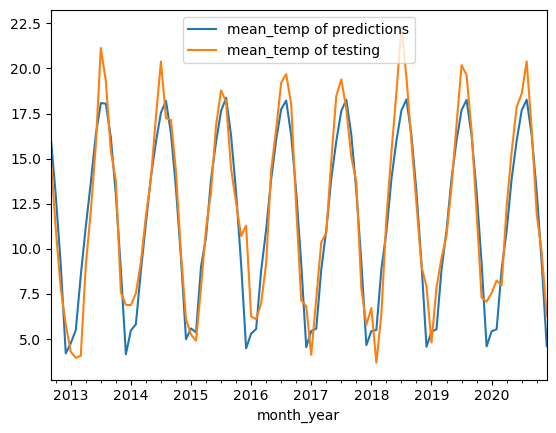

In [29]:
#Predictions of ARIMA Model against the test set
start = len(train)
end = len(df)+60 #next 60 months

# Predictions for one-year against the test set
predictions = result.predict(start, end, dynamic=True)#dynamic = True means new predicted values will be attached to the end of original datasets for further steps

# plot predictions and actual values on the same axis
predictions.iloc[:len(test)].plot(legend = True)
test['mean_temp'].plot(legend = True)

plt.legend(["mean_temp of predictions", "mean_temp of testing"])

plt.show()


In [35]:
predictions

2012-09    16.210476
2012-10    12.992825
2012-11     9.119179
2012-12     4.203807
2013-01     4.764654
             ...    
2025-09    16.297867
2025-10    13.177287
2025-11     9.215070
2025-12     4.594889
2026-01     5.421034
Freq: M, Name: predicted_mean, Length: 161, dtype: float64

In [32]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
RMSE=rmse(test["mean_temp"], predictions.iloc[:len(test)])
  
# Calculate mean squared error
ERROR=mean_squared_error(test["mean_temp"], predictions.iloc[:len(test)])

In [33]:
ERROR

2.967479208209042

In [34]:
RMSE

1.722637282833807

# Forecasting 5 years

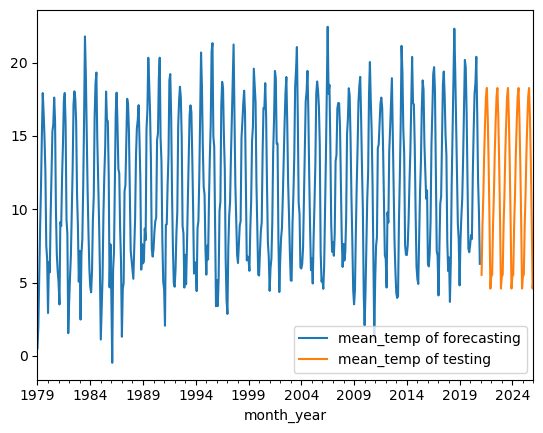

In [37]:
df['mean_temp'].plot(legend = True)
predictions.iloc[-60:].plot(legend = True)

plt.legend(["mean_temp of forecasting", "mean_temp of testing"])
plt.show()